# Complex source reconstruction using _starlets_
This notebooks aims to be a first tentative to express light on pixelated grid, and building the mapping between source and image planes, for an implementation in _lenstronomy_.

In [1]:
__author__ = 'aymgal'
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.plot_util import nice_colorbar

from MuSCADeT.MCA import mMCA as MuSCADeT_MCA
from MuSCADeT.MCA import PCA_initialise

%matplotlib inline

lensing_operator = 'interpol'  # 'interpol' or 'simple'
subgrid_res_source = 2

use_true_mixing = False
use_threshold_mask = False

formulation = 'analysis'
perfect_seeing = False


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.17.0    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

def mb2rgb(image_mb):
    """swap first and last dimension for plotting rgb images in pyplot"""
    image_rgb = np.zeros((image_mb.shape[1], image_mb.shape[2], image_mb.shape[0]))
    for nb in range(image_mb.shape[0]):
        image_rgb[:, :, nb] = image_mb[nb, :, :]
    return image_rgb

def mask_from_noise(image, bkg_rms, threshold_noise=5):
    image_1d = lenstro_util.image2array(image)
    image_mask_1d = np.zeros_like(image_1d)
    mask_indices = np.where(image_1d > threshold_noise * bkg_rms)
    image_mask_1d[mask_indices] = 1
    image_mask = lenstro_util.array2image(image_mask_1d)
    return image_mask

## Generate a mock lens

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.02  # background noise per pixel
#exp_time = 0  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

(41, 41)


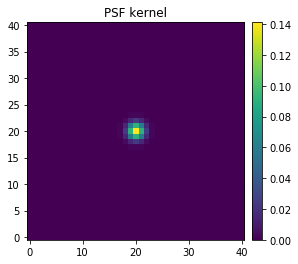

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': np.ones((num_pix, num_pix)) * exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF specification
if perfect_seeing:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)
psf_kernel = psf_class.kernel_point_source

plt.title("PSF kernel")
im = plt.imshow(psf_kernel, origin='lower')
nice_colorbar(im)
plt.show()

In [5]:
lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 1.6, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': -0.05, 'e2': 0.05}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
kwargs_sersic_ellipse_source2 = {'amp': 100, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                                'center_x': -0.4, 'center_y': 0.3}
kwargs_sersic_ellipse_source1 = {'amp': 80, 'R_sersic': 0.4, 'n_sersic': 1, 'e1': -0.02, 'e2': 0.02,
                                'center_x': -0.2, 'center_y': -0.1}
kwargs_source = [kwargs_sersic_ellipse_source1, kwargs_sersic_ellipse_source2]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [{'amp': 100, 'R_sersic': 1, 'n_sersic': 1, 'e1': kwargs_spemd['e1'], 'e2': kwargs_spemd['e2'],
                      'center_x': kwargs_spemd['center_x'], 'center_y': kwargs_spemd['center_y']}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

In [6]:
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
#data_class.update_data(image_sim)
data_class = ImageData(**kwargs_data)

In [7]:
# get the coordinates arrays of source plane (those are 'thetas' but in source plane !)
x_grid_src_1d, y_grid_src_1d = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix, 
                                                      subgrid_res=subgrid_res_source)

# get the light distribution in source plane on high res grid
source_sim_1d_hd = source_model_class.surface_brightness(x_grid_src_1d, y_grid_src_1d, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_1d_hd)

# get the light distribution in source plane
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

# get the light distribution in source plane convolved
source_sim_conv = imageModel.source_surface_brightness(kwargs_source, unconvolved=False, de_lensed=True)
source_sim_1d_conv = lenstro_util.image2array(source_sim)

# get the image with lens subtracted
image_sim_no_lens = imageModel.source_surface_brightness(kwargs_source, kwargs_lens=kwargs_lens, unconvolved=False, de_lensed=False)

In [8]:
# get an automatic mask that includes the lensed source light
threshold_noise = 5
image_mask = mask_from_noise(image_sim, background_rms, threshold_noise=threshold_noise)

## Visualize the lens & true source

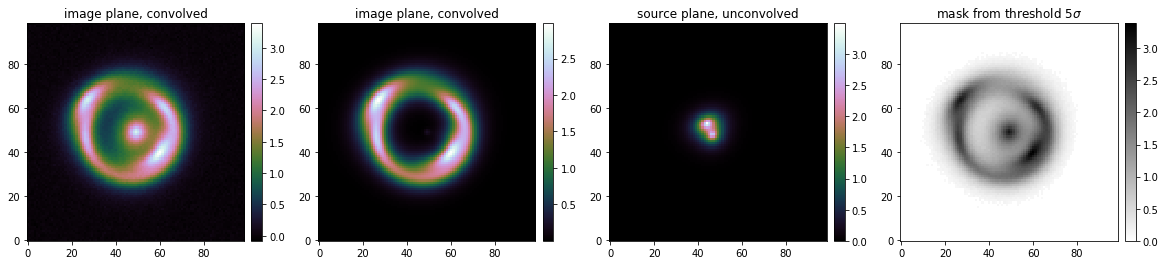

In [9]:
fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 4), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 1), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim_no_lens), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 2))
ax.set_title("source plane, unconvolved")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 3))
ax.set_title("mask from threshold {}$\sigma$".format(threshold_noise))
im = ax.imshow(image_mask*image_sim, origin='lower', cmap='gray_r')
nice_colorbar(im)

plt.show()

## Make it a multiband image
We simply assign linear coefficient to each band.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 2) [[0.4375 0.28  ]
 [0.3125 0.32  ]
 [0.25   0.4   ]]
(2, 99, 99)
(3, 99, 99) -0.06651321406681274 1.2966511934829892


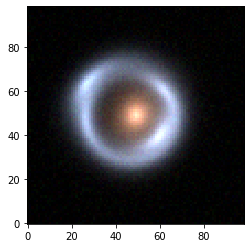

In [10]:
# bands order : 'red', 'green', 'blue'
num_bands = 3
mixing_true = np.array([
    [0.35, 0.25, 0.2],  # lens light
    [0.14, 0.16, 0.2],  # source light
]).T
assert mixing_true.shape[0] == num_bands
mixing_true /= np.sum(mixing_true, axis=0)  # normalisation so columns sum to 1
print(mixing_true.shape, mixing_true)

source_morpho_true = imageModel.source_surface_brightness(kwargs_source, kwargs_lens=kwargs_lens, unconvolved=False, de_lensed=False)
lens_light_morpho_true = imageModel.lens_surface_brightness(kwargs_lens_light, unconvolved=False)
morpho_true = np.array([lens_light_morpho_true, source_morpho_true])
print(morpho_true.shape)

image_sim_mb = np.zeros((num_bands, num_pix, num_pix))
for nb in range(num_bands):
    # mix source and lens light
    image_sim_mb[nb, :, :] = mixing_true[nb, 0]*morpho_true[0, :, :] + mixing_true[nb, 1]*morpho_true[1, :, :]
    # add noise
    image_sim_mb[nb, :, :] += image_util.add_background(image_sim_mb[nb, :, :], sigma_bkd=background_rms)
print(image_sim_mb.shape, image_sim_mb.min(), image_sim_mb.max())

from astropy.visualization import make_lupton_rgb
#image_sim_rgb_lupton = make_lupton_rgb(*image_sim_mb, minimum=background_rms, stretch=0.2)
plt.imshow(mb2rgb(image_sim_mb), origin='lower')
plt.show()

In [11]:
# define PSF for each band

# for simplicity we choose the same PSF for all bands
psf_kernel_mb = np.zeros((mixing_true.shape[0], psf_kernel.shape[0], psf_kernel.shape[1]))
for nb in range(num_bands):
    psf_kernel_mb[nb, :, :] = psf_kernel
print(psf_kernel_mb.shape)

(3, 41, 41)


## Remove lens light with MuSCADeT

=== Running PCA_initialise ===
using lvl (including coarse scale !) 6
mode : PCA
svd going on
svd done


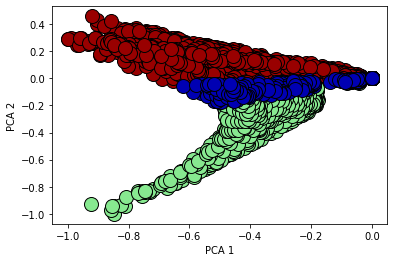

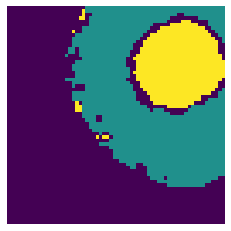

deconvolution : True
6749.331832258359
0
threshold from MOM 5546.05676478639
threshold from MOM 4792.572462294451
threshold from MOM 3767.960963977713
threshold from MOM 2855.1526175765302
10
threshold from MOM 2445.1461911998135
threshold from MOM 2032.2018091663595
threshold from MOM 1534.0785711112937
threshold from MOM 865.4851259415548
threshold from MOM 378.050278629818
threshold from MOM 266.6844109253288
threshold from MOM 205.0618359430273
threshold from MOM 197.73195753085386
threshold from MOM 186.72022917724613
threshold from MOM 183.27081164488013
20
threshold from MOM 169.3898200164587
threshold from MOM 161.85536958356093
threshold from MOM 149.11110888921147
threshold from MOM 140.50279357486943
threshold from MOM 132.4416433172522
threshold from MOM 122.71138720126467
threshold from MOM 118.5263364704735
30
threshold from MOM 116.24012784104603
threshold from MOM 113.86201037681923
threshold from MOM 110.35038890639626
threshold from MOM 108.64105429163841
threshold fr

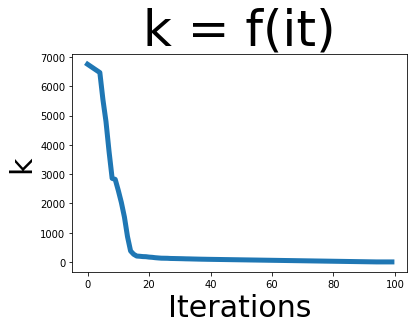

In [12]:
# format correctly
Y = image_sim_mb
H = psf_kernel_mb

n_sources = 2  # source and lens light
n_iter = 100   # number of iterations
n_sig = 5     # threshold in units of noise standard deviation
lvl = 0        # starlet number of scales (0 for the maximum possible)
pos = True    # force positivity
newwave = 1
harder = 1

# initialize A through PCA
#angle_pca = 32
#alpha_pca = [0, 0]
#n_pca = 32

if not use_true_mixing:
    print("=== Running PCA_initialise ===")
    #A_prior = PCA_initialise(Y.T, n_sources, angle=angle_pca, alpha=alpha_pca, npca=n_pca, 
    #                         plot=1, newwave=newwave)
    S_est, A_est = MuSCADeT_MCA(Y, None, n_sig, n_iter, mode='PCA', lvl=lvl, 
                                PSF=H, pos=pos, harder=harder, newwave=newwave, plot=True)
else:
    A_prior = mixing_true
    print("=== Running MuSCADeT ===")
    S_est, A_est = MuSCADeT_MCA(Y, A_prior, n_sig, n_iter, PCA=None, mode='noPCA', lvl=lvl, 
                                PSF=H, pos=pos, harder=harder, newwave=newwave, plot=True)

# make sure that output is correctly formatted
A_est = A_est.reshape(mixing_true.shape[0], n_sources)
S_est = S_est.reshape(n_sources, num_pix**2)

In [13]:

# to make sure the order in the estimated mixing matrix is consistent with true one
# we switch columns to match teh convention first column = lens component, second column = source component
# the criterion used is the amplitude of the first mixing coeff
if A_est[0, 0] < A_est[0, 1]:
    # means first component is redder than second, so source might be first component, so we switch A columns
    A_est[:, [0, 1]] = A_est[:, [1, 0]]
    S_est[[0, 1], :] = S_est[[1, 0], :]
    print("A columns swapped")
else:
    # the order is correct
    pass

A columns swapped


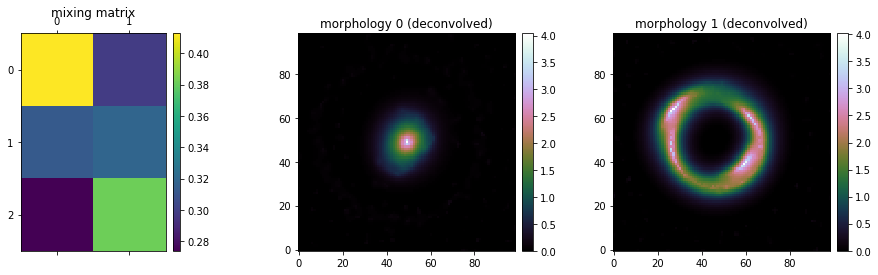

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
ax = axes[0]
ax.set_title("mixing matrix")
im = ax.matshow(A_est)
nice_colorbar(im)
for ns in range(n_sources):
    ax = axes[ns+1]
    ax.set_title("morphology {} (deconvolved)".format(ns))
    im = ax.imshow(S_est[ns, :].reshape(num_pix, num_pix), origin='lower', cmap='cubehelix')
    nice_colorbar(im)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


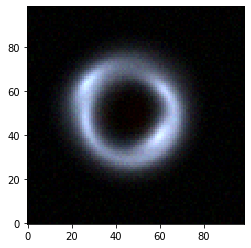

In [15]:
# subtract lens light from multiband image
lens_light_mb = np.outer(A_est[:, 0], S_est[0, :]).reshape(num_bands, num_pix, num_pix)
source_mb = np.outer(A_est[:, 1], S_est[1, :]).reshape(num_bands, num_pix, num_pix)

# convolve with PSF in each band
from scipy import signal
for nb in range(num_bands):
    lens_light_mb[nb, :, :] = signal.fftconvolve(lens_light_mb[nb, :, :], psf_kernel_mb[nb, :, :], mode='same')
    source_mb[nb, :, :] = signal.fftconvolve(source_mb[nb, :, :], psf_kernel_mb[nb, :, :], mode='same')

# subtract lens light from data
image_sim_mb_lenssub = image_sim_mb - lens_light_mb

plt.imshow(mb2rgb(image_sim_mb_lenssub), origin='lower')
plt.show()

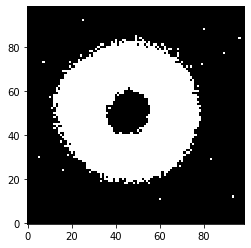

In [16]:
# define masks
image_mask_mb = []
for nb in range(num_bands):
    image_mask_band = mask_from_noise(image_sim_mb_lenssub[nb, :, :], background_rms, threshold_noise=3)
    image_mask_mb.append(image_mask_band)
plt.imshow(image_mask_mb[-1], origin='lower', cmap='gray')
plt.show()

## Sparse optimizazion to reconstruct the source light

In [17]:
source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': 4, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

if use_threshold_mask:
    likelihood_mask = image_mask.astype(bool)
else:
    likelihood_mask = None

kwargs_sparse_solver = {
    'lensing_operator': lensing_operator,
    
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': False,
    'min_num_pix_source': 80,
    
    'formulation': formulation,
    'force_positivity': True,
    'sparsity_prior_norm': 1,
    'max_threshold': 5,
    'max_threshold_high_freq': 10,
    'num_iter': 200,
    'num_iter_weights': 1,
    'verbose': True,
    'show_steps': True,
}

=== fitting band 0 ===


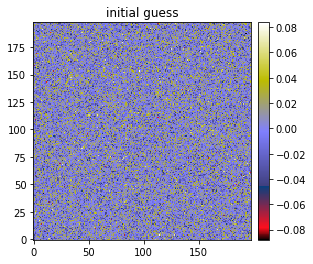

=== iteration 0-0 === : loss = 0.7412|nan, red-chi2 = 1.4179|nan, step_diff = 151.6523|nan


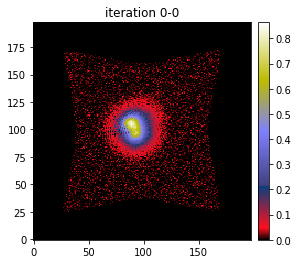

=== iteration 0-30 === : loss = 0.1622|nan, red-chi2 = 0.9430|nan, step_diff = 0.0001|nan
=== iteration 0-60 === : loss = 0.1475|nan, red-chi2 = 0.9273|nan, step_diff = 0.0000|nan
=== iteration 0-90 === : loss = 0.1424|nan, red-chi2 = 0.9208|nan, step_diff = 0.0000|nan


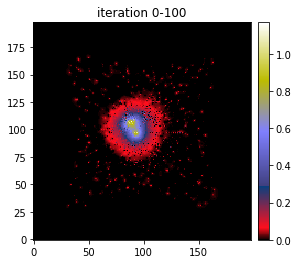

=== iteration 0-120 === : loss = 0.1401|nan, red-chi2 = 0.9172|nan, step_diff = 0.0000|nan
=== iteration 0-150 === : loss = 0.1389|nan, red-chi2 = 0.9149|nan, step_diff = 0.0000|nan
=== iteration 0-180 === : loss = 0.1384|nan, red-chi2 = 0.9135|nan, step_diff = 0.0000|nan


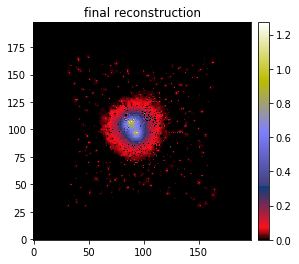

> runtime for band 0 : 8.975 s
> updated kwargs : [{'n_scales': 4, 'n_pixels': 39204, 'scale': 0.039999999999999994, 'coeffs': array([0., 0., 0., ..., 0., 0., 0.])}]
=== fitting band 1 ===


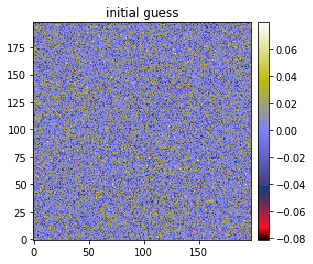

=== iteration 0-0 === : loss = 1.2954|nan, red-chi2 = 1.5524|nan, step_diff = 194.1189|nan
=== iteration 0-30 === : loss = 0.1557|nan, red-chi2 = 0.9199|nan, step_diff = 0.0001|nan
=== iteration 0-60 === : loss = 0.1478|nan, red-chi2 = 0.9085|nan, step_diff = 0.0000|nan
=== iteration 0-90 === : loss = 0.1457|nan, red-chi2 = 0.9035|nan, step_diff = 0.0000|nan
=== iteration 0-120 === : loss = 0.1448|nan, red-chi2 = 0.9006|nan, step_diff = 0.0000|nan
=== iteration 0-150 === : loss = 0.1442|nan, red-chi2 = 0.8988|nan, step_diff = 0.0000|nan
=== iteration 0-180 === : loss = 0.1438|nan, red-chi2 = 0.8976|nan, step_diff = 0.0000|nan
> runtime for band 1 : 8.516 s
> updated kwargs : [{'n_scales': 4, 'n_pixels': 39204, 'scale': 0.039999999999999994, 'coeffs': array([0., 0., 0., ..., 0., 0., 0.])}]
=== fitting band 2 ===


In [ ]:
kwargs_lens_mod = copy.deepcopy(kwargs_lens)
#kwargs_lens_mod[0]['gamma'] = kwargs_lens[0]['gamma'] * 1.1

data_class_band = copy.deepcopy(data_class)

sparse_fit_list = []
kwargs_source_list = []
model_mb = []  # model (i.e. lensed source)
model_delensed_deconv_mb  = []  # unconvolded & delensed source
model_delensed_resized_mb = []  # convolded & re-sized to original grid
for nb in range(num_bands):
    kwargs_sparse_solver['show_steps'] = True if nb == 0 else False
    print("=== fitting band {} ===".format(nb))
    image_band = image_sim_mb_lenssub[nb, :, :]
    data_class_band.update_data(image_band)
    likelihood_mask = image_mask_mb[nb] if use_threshold_mask else None
    imageSparseFit = ImageSparseFit(data_class_band, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)
    start_time = time.time()
    model, model_error = imageSparseFit.image_sparse_solve(kwargs_lens_mod, kwargs_source=kwargs_source_sparsefit,
                                                          kwargs_lens_light=None)
    end_time = time.time()
    print("> runtime for band {} : {:.3f} s".format(nb, end_time-start_time))
    print("> updated kwargs :", kwargs_source_sparsefit)
    sparse_fit_list.append(imageSparseFit)
    kwargs_source_list.append(copy.deepcopy(kwargs_source_sparsefit))
    model_mb.append(model)
    model_delensed_deconv = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None,
                                                              unconvolved=True, de_lensed=True, 
                                                              re_sized=False, original_grid=False)
    model_delensed_deconv_mb.append(model_delensed_deconv)

## Plot colored reconstructed source

In [ ]:
model_mb = np.asarray(model_mb).reshape(num_bands, num_pix, num_pix)
num_pix_source = model_delensed_deconv_mb[-1].shape[0]
model_delensed_deconv_mb = np.asarray(model_delensed_deconv_mb).reshape(num_bands, num_pix_source, num_pix_source)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.set_title("model")
ax.imshow(mb2rgb(model_mb), origin='lower')
ax = axes[1]
ax.set_title("deconvolved source")
ax.imshow(mb2rgb(model_delensed_deconv_mb), origin='lower')
plt.show()

## Plot results in image plane

In [ ]:
sparse_fit_single = sparse_fit_list[-1]  # select band to plot
sparse_fit_single.sparseSolver.plotter.plot_results(model_log_scale=False, res_vmin=-6, res_vmax=6)

## Residuals in source plane

In [ ]:
# real colored source
source_morpho_delensed_deconv_true = imageModel.source_surface_brightness(kwargs_source, kwargs_lens=kwargs_lens,
                                                                          unconvolved=False, de_lensed=True)
source_mb_true = np.outer(mixing_true[:, 1], lenstro_util.image2array(source_morpho_delensed_deconv_true))
source_mb_true = source_mb_true.reshape(num_bands, num_pix, num_pix)

# reconstructed colored source on same grid


plt.imshow(mb2rgb(source_mb_true), origin='lower')